In [1]:
import pickle
from distutils.dir_util import copy_tree
from IPython.display import clear_output
import numpy as np
import pandas as pd

main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/"

def readpkl(main_path, outdir):
    file_path = f"{main_path}{outdir}/result_dictionary.pkl"
    category_labels=["state"]
    # Check if the file exists
    with open(file_path, "rb") as f:
        simulation_results = pickle.load(f)
        print("File loaded successfully.")
        
    runs=100
    organized_results={}

    data_frames_to_merge = []
    result_names=[]
    for run in range(runs):
        result_name=f'run_{run}'
        temp_df=simulation_results[result_name].copy()
        temp_df['run']=run

        data_frames_to_merge.append(temp_df)    
    organized_results=pd.concat(data_frames_to_merge)
    return organized_results

atob_outdir="nbonlyrealistic_simulation_alpha_to_beta"
ttoc_outdir="nbonlyrealistic_simulation_beta_t2d_to_control"
wheel_outdir="nbonlyrealistic_simulation_alpha_to_beta_custom"
atob=readpkl(main_path,atob_outdir)
ttoc=readpkl(main_path,ttoc_outdir)
wheel=readpkl(main_path,wheel_outdir)


File loaded successfully.
File loaded successfully.
File loaded successfully.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_gene_score_vs_rank(
    dataframe: pd.DataFrame,
    label_col: str,
    score_col: str,
    percentile: float = 95,
    max_unique_colors: int = 10,
    colormap: str = "tab10"
) -> pd.DataFrame:
    """
    Plots rank (x) vs mean score (y) for each gene, with 95 % CIs.
    Top-percentile genes are highlighted in unique colours.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Input data containing gene labels and scores.
    label_col : str
        Column name that holds gene identifiers.
    score_col : str
        Column name that holds the score to be ranked.
    percentile : float, default 95
        Percentile threshold for selecting "top" genes to colour uniquely.
    max_unique_colors : int, default 10
        Maximum number of distinct colours for the highlighted genes.
    colormap : str, default 'tab10'
        Matplotlib colormap used for top-gene colouring.

    Returns
    -------
    pd.DataFrame
        A two-column DataFrame with the mean score and rank for each gene.
    """
    # ── 1. Aggregate to mean and SEM per gene ────────────────────────────────────
    grouped = dataframe.groupby(label_col)[score_col]
    stats = grouped.agg(["mean", "sem"]).reset_index()
    stats.rename(columns={"mean": "score_mean", "sem": "score_sem"}, inplace=True)

    # ── 2. Rank genes by mean score (1 = best) ───────────────────────────────────
    stats.sort_values("score_mean", ascending=False, inplace=True)
    stats["rank"] = np.arange(1, len(stats) + 1)

    # ── 3. Select top genes for special colouring ───────────────────────────────
    percentile_threshold = np.percentile(stats["score_mean"], percentile)
    top_candidates = stats[stats["score_mean"] >= percentile_threshold]
    top_genes = top_candidates.head(max_unique_colors)[label_col].tolist()

    # Colour map for highlighted genes
    cmap = plt.colormaps[colormap]
    colours = {gene: cmap(i / max_unique_colors) for i, gene in enumerate(top_genes)}

    # ── 4. Plot ─────────────────────────────────────────────────────────────────
    plt.figure(figsize=(12, 6))

    # Non-top genes (faint black)
    non_top = stats[~stats[label_col].isin(top_genes)]
    plt.errorbar(
        non_top["rank"],
        non_top["score_mean"],
        yerr=1.96 * non_top["score_sem"],
        fmt="o",
        ecolor="black",
        color="black",
        alpha=0.1,
        linestyle="none",
    )

    # Highlighted top genes
    for gene in top_genes:
        row = stats[stats[label_col] == gene].iloc[0]
        plt.errorbar(
            row["rank"],
            row["score_mean"],
            yerr=1.96 * row["score_sem"],
            fmt="o",
            color=colours[gene],
            ecolor=colours[gene],
            label=f"{gene} (score = {row['score_mean']:.2f})",
            markersize=6,
            linestyle="none",
        )

    # ── 5. Aesthetics ───────────────────────────────────────────────────────────
    plt.gca().invert_xaxis()          # so rank 1 appears on the left
    plt.xlabel("Rank (1 = highest score)")
    plt.ylabel(f"Mean {score_col}")
    plt.title("Gene Rank vs Score (95 % CI)")
    plt.grid(False)
    plt.tight_layout()
    if top_genes:
        plt.legend(title="Top genes", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()

    return stats[["rank", "score_mean", label_col]]


<Axes: >

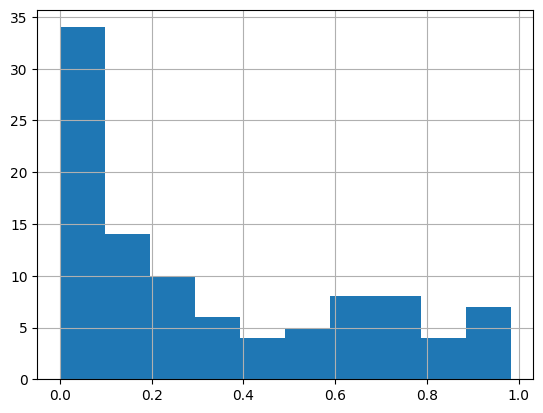

In [3]:
wheel[wheel['label']=='FTH1']['oracle_score_pval'].hist()

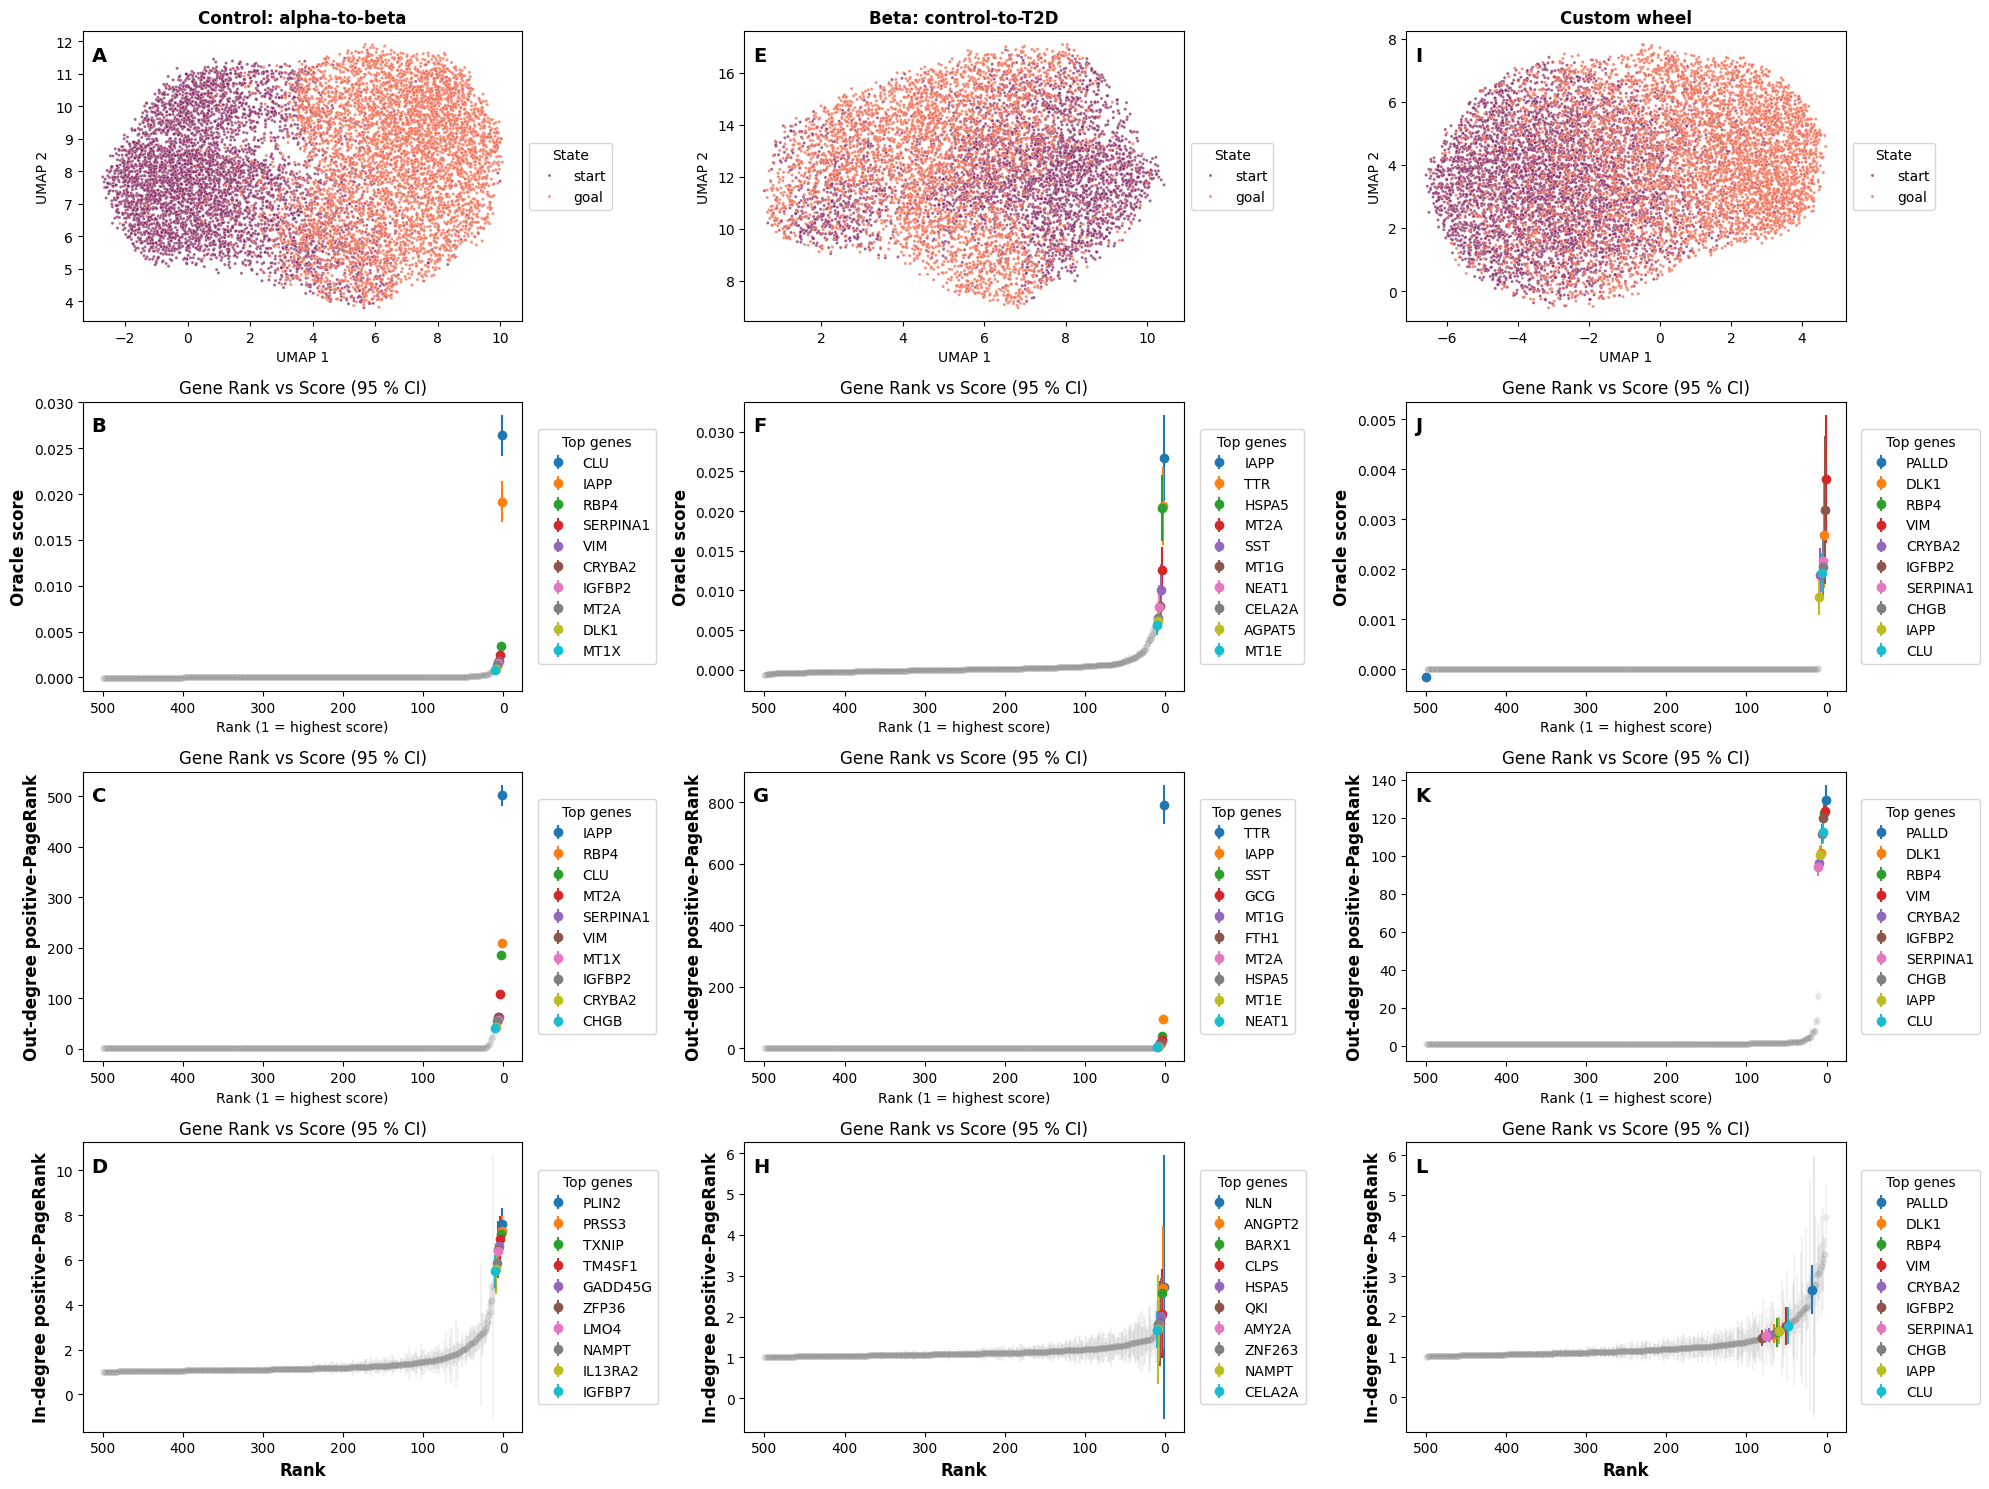

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_gene_score_vs_rank(
    dataframe: pd.DataFrame,
    label_col: str,
    score_col: str,
    max_unique_colors: int = 10,
    colormap: str = "tab10",
    ax: plt.Axes | None = None,
) -> plt.Axes:
    """
    Plot rank (x-axis) versus mean score (y-axis) for every gene, with 95 % CIs.
    The first `max_unique_colors` genes ranked by mean score are highlighted
    with distinct colours; all other genes appear in faint grey.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Data containing at least `label_col` and `score_col`.
    label_col : str
        Column holding gene identifiers.
    score_col : str
        Column holding the numeric score to be ranked.
    max_unique_colors : int, default 10
        How many top-ranked genes to colour uniquely.
    colormap : str, default 'tab10'
        Matplotlib colormap for the highlighted genes.
    ax : matplotlib.axes.Axes | None, optional
        Axis to draw on; if None, a new figure/axis is created.

    Returns
    -------
    matplotlib.axes.Axes
        The axis containing the finished plot.
    """
    # ── set up axis ────────────────────────────────────────────────────────────
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    # ── aggregate mean and SEM per gene ────────────────────────────────────────
    stats = (
        dataframe.groupby(label_col)[score_col]
        .agg(["mean", "sem"])
        .reset_index()
        .rename(columns={"mean": "score_mean", "sem": "score_sem"})
    )

    # ── rank genes by mean score (1 = best) ────────────────────────────────────
    stats.sort_values("score_mean", ascending=False, inplace=True)
    stats["rank"] = np.arange(1, len(stats) + 1)

    # ── choose the top N genes to colour ───────────────────────────────────────
    top_labels = stats.head(max_unique_colors)[label_col].tolist()

    # colormap for highlighted genes
    cmap = plt.colormaps[colormap]
    colour_map = {g: cmap(i / max_unique_colors) for i, g in enumerate(top_labels)}

    # ── plot non-top genes (faint grey) ────────────────────────────────────────
    non_top = stats[~stats[label_col].isin(top_labels)]
    ax.errorbar(
        non_top["rank"],
        non_top["score_mean"],
        yerr=1.96 * non_top["score_sem"],
        fmt="o",
        color="grey",
        ecolor="grey",
        alpha=0.1,
        ms=4,
        linestyle="none",
    )

    # ── plot highlighted genes ────────────────────────────────────────────────
    for gene in top_labels:
        row = stats.loc[stats[label_col] == gene].iloc[0]
        ax.errorbar(
            row["rank"],
            row["score_mean"],
            yerr=1.96 * row["score_sem"],
            fmt="o",
            ms=6,
            color=colour_map[gene],
            ecolor=colour_map[gene],
            label=gene,
            linestyle="none",
        )

    # ── styling ────────────────────────────────────────────────────────────────
    ax.invert_xaxis()  # rank 1 on the left
    ax.set_xlabel("Rank (1 = highest score)")
    ax.set_ylabel(f"Mean {score_col}")
    ax.set_title("Gene Rank vs Score (95 % CI)")
    ax.grid(False)
    if top_labels:
        ax.legend(title="Top genes", bbox_to_anchor=(1.02, 0.5), loc="center left")

    return ax


def plot_gene_score_vs_rank_custom(
    dataframe: pd.DataFrame,
    label_col: str,
    score_col: str,
    tocolor: list[str] | None = None,
    percentile: float = 95,
    max_unique_colors: int = 10,
    colormap: str = "tab10",
    ax: plt.Axes | None = None,
) -> plt.Axes:
    """
    Plot rank (x-axis) versus mean score (y-axis) for each gene with 95 % CIs.
    Genes whose mean score lies in the top ``percentile``—up to
    ``max_unique_colors``—get distinct colours.  
    If *tocolor* is supplied, that list overrides the percentile logic.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Input data with one row per observation.
    label_col : str
        Column holding gene identifiers.
    score_col : str
        Column holding the numeric score to be ranked.
    tocolor : list[str] | None, optional
        Explicit list of genes to highlight; if ``None`` the function
        selects genes above the ``percentile`` threshold.
    percentile : float, default 95
        Percentile cut-off that defines “top” genes (ignored if *tocolor*
        is provided).
    max_unique_colors : int, default 10
        Maximum number of distinct colours to assign.
    colormap : str, default 'tab10'
        Name of the Matplotlib colormap for highlighted genes.
    ax : matplotlib.axes.Axes | None, optional
        Axes to draw on.  If ``None`` a new figure and axes are created.

    Returns
    -------
    matplotlib.axes.Axes
        The axes with the finished plot.
    """
    # ── set up axes ────────────────────────────────────────────────────────────
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    # ── aggregate: mean and SEM per gene ───────────────────────────────────────
    stats = (
        dataframe.groupby(label_col)[score_col]
        .agg(["mean", "sem"])
        .reset_index()
        .rename(columns={"mean": "score_mean", "sem": "score_sem"})
    )

    # ── rank genes by mean score (1 = best) ────────────────────────────────────
    stats.sort_values("score_mean", ascending=False, inplace=True)
    stats["rank"] = np.arange(1, len(stats) + 1)

    # ── determine genes to colour ──────────────────────────────────────────────
    if tocolor is None:
        threshold = np.percentile(stats["score_mean"], percentile)
        tocolor = (
            stats.loc[stats["score_mean"] >= threshold, label_col]
            .head(max_unique_colors)
            .tolist()
        )
    else:
        tocolor = tocolor[:max_unique_colors]

    # colour palette
    cmap = plt.colormaps[colormap]
    colour_map = {g: cmap(i / max_unique_colors) for i, g in enumerate(tocolor)}

    # ── plot non-top genes (faint grey) ────────────────────────────────────────
    non_top = stats[~stats[label_col].isin(tocolor)]
    ax.errorbar(
        non_top["rank"],
        non_top["score_mean"],
        yerr=1.96 * non_top["score_sem"],
        fmt="o",
        color="grey",
        ecolor="grey",
        alpha=0.1,
        ms=4,
        linestyle="none",
    )

    # ── plot highlighted genes ────────────────────────────────────────────────
    for gene in tocolor:
        row = stats.loc[stats[label_col] == gene].iloc[0]
        ax.errorbar(
            row["rank"],
            row["score_mean"],
            yerr=1.96 * row["score_sem"],
            fmt="o",
            ms=6,
            color=colour_map[gene],
            ecolor=colour_map[gene],
            label=gene,
            linestyle="none",
        )

    # ── styling ────────────────────────────────────────────────────────────────
    ax.invert_xaxis()  # rank 1 on the left
    ax.set_xlabel("Rank (1 = highest score)")
    ax.set_ylabel(f"Mean {score_col}")
    ax.set_title("Gene Rank vs Score (95 % CI)")
    ax.grid(False)
    if tocolor:
        ax.legend(title="Top genes", bbox_to_anchor=(1.02, 0.5), loc="center left")

    return ax




def plot_umap(df, x_col, y_col, color_col, ax,title=""):
    """
    Plots a UMAP scatter plot colored by the given categorical variable.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        x_col (str): Column name for UMAP x-coordinates.
        y_col (str): Column name for UMAP y-coordinates.
        color_col (str): Column name for categorical coloring.
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
    """
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=color_col, alpha=0.7,s=5, ax=ax, palette="rocket")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.legend(title="State", loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=12, fontweight="bold")


def assemble_multiplot(dataframes, umap_data, score_columns, label_col, 
                        dataset_names=None, score_titles=None, x_axis_label=None):
    """
    Creates a 3x4 multi-plot where:
      - The first COLUMN contains UMAP visualizations for each dataset.
      - The next 3 COLUMNS contain score-based gene AUC plots.
      - Each ROW represents a dataset.
      - Shared Y-label per row (dataset name).
      - Shared X-label (custom, bottom row).
      - Independent Y-scales for AUC plots.
      - Labels A-L for each subplot.

    Parameters:
        dataframes (list of pd.DataFrame): List of 3 dataframes for AUC plots.
        umap_data (list of pd.DataFrame): List of 3 dataframes for UMAP plots.
        score_columns (list of str): List of 3 unique score columns.
        label_col (str): Column name for gene labels.
        zero_col (str): Column name for zero inflation.
        dataset_names (list of str, optional): Custom dataset names (row labels).
        score_titles (list of str, optional): Custom score type titles (column titles).
        x_axis_label (str, optional): Custom shared X-axis label.

    Returns:
        fig (matplotlib.figure.Figure): The figure containing all plots.
    """
    num_rows, num_cols = 4,3  # Adding UMAP column
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15), sharex=False, sharey=False)  
    axes = axes.flatten()  # Convert 2D array into 1D for easy indexing
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(num_rows)]  # Default row labels
    if score_titles is None:
        score_titles = score_columns  # Default column titles
    if x_axis_label is None:
        x_axis_label = zero_col  # Default X-axis label

    subplot_labels = ["A", "E", "I", "B", "F", "J", "C", "G", "K", "D", "H", "L"] 
    # A-L labels
    custom_labels=['PALLD','DLK1','RBP4','VIM','CRYBA2','IGFBP2','SERPINA1','CHGB','IAPP','CLU']
    plot_umap(umap_data[0], "umap1", "umap2", "state", ax=axes[0],title=dataset_names[0])
    plot_umap(umap_data[1], "umap1", "umap2", "state", ax=axes[1],title=dataset_names[1])
    plot_umap(umap_data[2], "umap1", "umap2", "state", ax=axes[2],title=dataset_names[2])

    plot_gene_score_vs_rank(dataframes[0], label_col, score_columns[0], ax=axes[3])
    plot_gene_score_vs_rank(dataframes[0], label_col, score_columns[1], ax=axes[6])
    plot_gene_score_vs_rank(dataframes[0], label_col, score_columns[2], ax=axes[9])
    plot_gene_score_vs_rank(dataframes[1], label_col, score_columns[0], ax=axes[4])
    plot_gene_score_vs_rank(dataframes[1], label_col, score_columns[1], ax=axes[7])
    plot_gene_score_vs_rank(dataframes[1], label_col, score_columns[2], ax=axes[10])
    plot_gene_score_vs_rank_custom(dataframes[2], label_col, score_columns[0],tocolor=custom_labels, ax=axes[5])
    plot_gene_score_vs_rank_custom(dataframes[2], label_col, score_columns[1],tocolor=custom_labels, ax=axes[8])
    plot_gene_score_vs_rank_custom(dataframes[2], label_col, score_columns[2],tocolor=custom_labels, ax=axes[11])


    axes[3].set_ylabel(score_titles[0], fontsize=12, fontweight="bold")
    axes[4].set_ylabel(score_titles[0], fontsize=12, fontweight="bold")
    axes[5].set_ylabel(score_titles[0], fontsize=12, fontweight="bold")
    axes[6].set_ylabel(score_titles[1], fontsize=12, fontweight="bold")
    axes[7].set_ylabel(score_titles[1], fontsize=12, fontweight="bold")
    axes[8].set_ylabel(score_titles[1], fontsize=12, fontweight="bold")
    axes[9].set_ylabel(score_titles[2], fontsize=12, fontweight="bold")
    axes[10].set_ylabel(score_titles[2], fontsize=12, fontweight="bold")
    axes[11].set_ylabel(score_titles[2], fontsize=12, fontweight="bold")
    axes[9].set_xlabel(x_axis_label, fontsize=12, fontweight="bold")
    axes[10].set_xlabel(x_axis_label, fontsize=12, fontweight="bold")
    axes[11].set_xlabel(x_axis_label, fontsize=12, fontweight="bold")





    axes[0].text(0.02, 0.95, subplot_labels[0], transform=axes[0].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[1].text(0.02, 0.95, subplot_labels[1], transform=axes[1].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[2].text(0.02, 0.95, subplot_labels[2], transform=axes[2].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[3].text(0.02, 0.95, subplot_labels[3], transform=axes[3].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[4].text(0.02, 0.95, subplot_labels[4], transform=axes[4].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[5].text(0.02, 0.95, subplot_labels[5], transform=axes[5].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[6].text(0.02, 0.95, subplot_labels[6], transform=axes[6].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[7].text(0.02, 0.95, subplot_labels[7], transform=axes[7].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[8].text(0.02, 0.95, subplot_labels[8], transform=axes[8].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[9].text(0.02, 0.95, subplot_labels[9], transform=axes[9].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[10].text(0.02, 0.95, subplot_labels[10], transform=axes[10].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[11].text(0.02, 0.95, subplot_labels[11], transform=axes[11].transAxes,fontsize=14, fontweight="bold", va="top")  
    plt.tight_layout()
    plt.show()
    return fig

umapa2b=pd.read_csv(f"{main_path}{atob_outdir}/alphatobetaUMAP.csv")
umapwheel=pd.read_csv(f"{main_path}{wheel_outdir}/customalphatobetaUMAP.csv")
umapttoc=pd.read_csv(f"{main_path}{ttoc_outdir}/t2dtocontrolUMAP.csv")
# Example usage with three dataframes and three score columns
dataframes = [atob, ttoc, wheel]  # Replace with actual DataFrames
score_columns = ['oracle_score', 'out_degree_pagerank_positive','in_degree_pagerank_positive']  # Replace with actual column names

fig = assemble_multiplot(
    dataframes=dataframes, 
    umap_data=[umapa2b, umapttoc, umapwheel], 
    score_columns=score_columns,
    label_col='label',
    dataset_names=['Control: alpha-to-beta', 'Beta: control-to-T2D', 'Custom wheel'],
    score_titles=['Oracle score', 'Out-degree positive-PageRank', 'In-degree positive-PageRank'],      # Custom column titles
    x_axis_label='Rank'  # Custom X-axis label
)

fig.savefig(main_path+'nozig_SimulationResults.png')

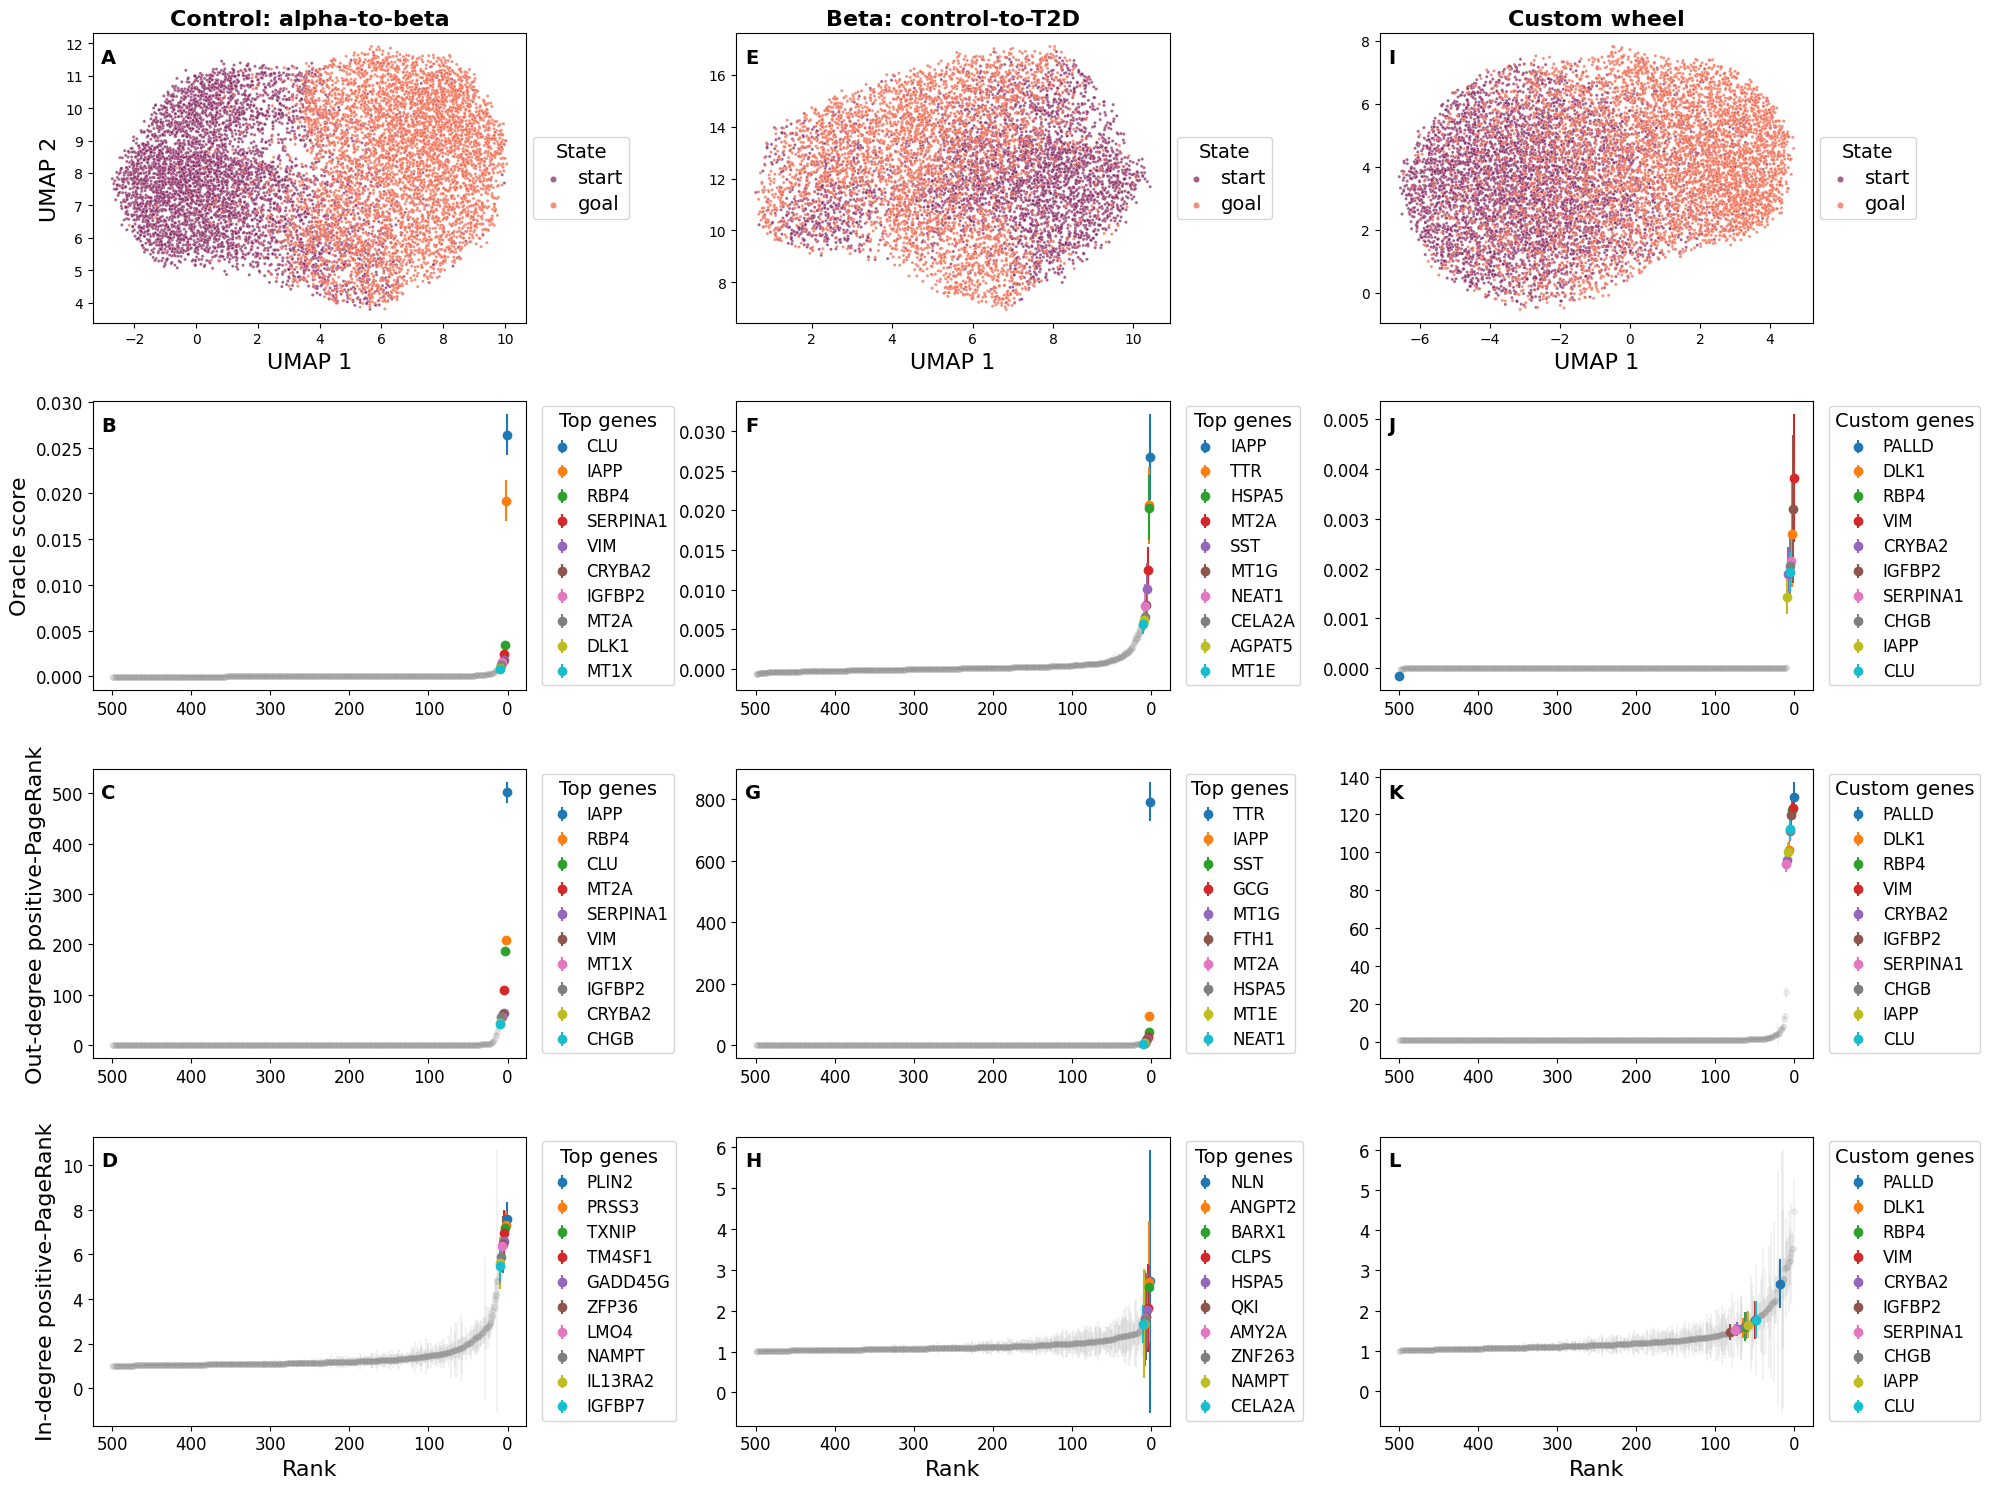

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_gene_score_vs_rank(
    dataframe: pd.DataFrame,
    label_col: str,
    score_col: str,
    max_unique_colors: int = 10,
    colormap: str = "tab10",
    ax: plt.Axes | None = None,
) -> plt.Axes:
    """
    Plot rank (x-axis) versus mean score (y-axis) for every gene, with 95 % CIs.
    The first `max_unique_colors` genes ranked by mean score are highlighted
    with distinct colours; all other genes appear in faint grey.

    All text is set to be legible in a 12 pt–font manuscript with 1″ margins.
    """
    # ── set up axis ────────────────────────────────────────────────────────────
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    # ── compute stats ──────────────────────────────────────────────────────────
    stats = (
        dataframe.groupby(label_col)[score_col]
        .agg(["mean", "sem"])
        .reset_index()
        .rename(columns={"mean": "score_mean", "sem": "score_sem"})
    )

    # ── rank genes ─────────────────────────────────────────────────────────────
    stats.sort_values("score_mean", ascending=False, inplace=True)
    stats["rank"] = np.arange(1, len(stats) + 1)

    # ── pick top genes ─────────────────────────────────────────────────────────
    top_labels = stats.head(max_unique_colors)[label_col].tolist()
    cmap = plt.colormaps[colormap]
    colour_map = {g: cmap(i / max_unique_colors) for i, g in enumerate(top_labels)}

    # ── non-top in grey ────────────────────────────────────────────────────────
    non_top = stats[~stats[label_col].isin(top_labels)]
    ax.errorbar(
        non_top["rank"],
        non_top["score_mean"],
        yerr=1.96 * non_top["score_sem"],
        fmt="o",
        color="grey",
        ecolor="grey",
        alpha=0.1,
        ms=4,
        linestyle="none",
    )

    # ── highlighted genes ─────────────────────────────────────────────────────
    for gene in top_labels:
        row = stats.loc[stats[label_col] == gene].iloc[0]
        ax.errorbar(
            row["rank"],
            row["score_mean"],
            yerr=1.96 * row["score_sem"],
            fmt="o",
            ms=6,
            color=colour_map[gene],
            ecolor=colour_map[gene],
            label=gene,
            linestyle="none",
        )

    # ── styling ────────────────────────────────────────────────────────────────
    ax.invert_xaxis()
    ax.set_xlabel("Rank (1 = highest score)")
    ax.set_ylabel(f"Mean {score_col}")
    ax.set_title("Gene Rank vs Score (95 % CI)")
    ax.grid(False)
    leg = None
    if top_labels:
        leg = ax.legend(title="Top genes", bbox_to_anchor=(1.02, 0.5), loc="center left")

    # ── font sizing for 12 pt paper ────────────────────────────────────────────
    # axis titles and figure title
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)
    ax.title.set_fontsize(14)
    # tick labels
    ax.tick_params(axis="both", labelsize=12)
    # legend text
    if leg:
        # legend.title is a Text object
        leg.get_title().set_fontsize(14)
        for txt in leg.get_texts():
            txt.set_fontsize(12)

    return ax

import numpy as np
import matplotlib.pyplot as plt

def plot_gene_score_vs_rank_custom(
    dataframe: pd.DataFrame,
    label_col: str,
    score_col: str,
    tocolor: list[str] | None = None,
    percentile: float = 95,
    max_unique_colors: int = 10,
    colormap: str = "tab10",
    ax: plt.Axes | None = None,
) -> plt.Axes:
    """
    Plot rank (x-axis) versus mean score (y-axis) for each gene with 95 % CIs.
    Genes whose mean score lies in the top ``percentile``—up to
    ``max_unique_colors``—get distinct colours.  
    If *tocolor* is supplied, that list overrides the percentile logic.

    All text sizes are tuned for a 6×4″ figure in a 12 pt–font paper with 1″ margins.
    """
    # ── set up axes ────────────────────────────────────────────────────────────
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    # ── aggregate: mean and SEM per gene ───────────────────────────────────────
    stats = (
        dataframe.groupby(label_col)[score_col]
        .agg(["mean", "sem"])
        .reset_index()
        .rename(columns={"mean": "score_mean", "sem": "score_sem"})
    )

    # ── rank genes by mean score (1 = best) ────────────────────────────────────
    stats.sort_values("score_mean", ascending=False, inplace=True)
    stats["rank"] = np.arange(1, len(stats) + 1)

    # ── determine genes to colour ──────────────────────────────────────────────
    if tocolor is None:
        threshold = np.percentile(stats["score_mean"], percentile)
        tocolor = (
            stats.loc[stats["score_mean"] >= threshold, label_col]
            .head(max_unique_colors)
            .tolist()
        )
    else:
        tocolor = tocolor[:max_unique_colors]

    # ── build colour map ───────────────────────────────────────────────────────
    cmap = plt.colormaps[colormap]
    colour_map = {g: cmap(i / max_unique_colors) for i, g in enumerate(tocolor)}

    # ── plot non-top genes (faint grey) ────────────────────────────────────────
    non_top = stats[~stats[label_col].isin(tocolor)]
    ax.errorbar(
        non_top["rank"],
        non_top["score_mean"],
        yerr=1.96 * non_top["score_sem"],
        fmt="o",
        color="grey",
        ecolor="grey",
        alpha=0.1,
        ms=4,
        linestyle="none",
    )

    # ── plot highlighted genes ────────────────────────────────────────────────
    for gene in tocolor:
        row = stats.loc[stats[label_col] == gene].iloc[0]
        ax.errorbar(
            row["rank"],
            row["score_mean"],
            yerr=1.96 * row["score_sem"],
            fmt="o",
            ms=6,
            color=colour_map[gene],
            ecolor=colour_map[gene],
            label=gene,
            linestyle="none",
        )

    # ── styling ────────────────────────────────────────────────────────────────
    ax.invert_xaxis()  # rank 1 on the left
    ax.set_xlabel("Rank (1 = highest score)")
    ax.set_ylabel(f"Mean {score_col}")
    ax.set_title("Gene Rank vs Score (95 % CI)")
    ax.grid(False)

    leg = None
    if tocolor:
        leg = ax.legend(title="Custom genes", bbox_to_anchor=(1.02, 0.5), loc="center left")

    # ── font sizing for 12 pt paper ────────────────────────────────────────────
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)
    ax.title.set_fontsize(14)
    ax.tick_params(axis="both", labelsize=12)
    if leg:
        leg.get_title().set_fontsize(14)
        for txt in leg.get_texts():
            txt.set_fontsize(12)

    return ax

def plot_umap(df, x_col, y_col, color_col, ax, title=""):
    """
    Plots a UMAP scatter plot colored by the given categorical variable.

    All text sizes are tuned for a 6×4″ figure in a 12 pt–font paper with 1″ margins.
    """
    # scatter
    sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=color_col,
        alpha=0.7,
        s=5,
        ax=ax,
        palette="rocket",
        legend="brief"  # ensure we get a legend
    )

    # labels and title at 12 pt
    ax.set_xlabel("UMAP 1", fontsize=16)
    ax.set_ylabel("UMAP 2", fontsize=16)
    ax.set_title(title, fontsize=16, fontweight="bold")

    # tick labels at 10 pt
    ax.tick_params(axis="both", labelsize=10)

    # legend with larger dots: markerscale controls the marker size in the legend
    leg = ax.legend(
        title="State",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        markerscale=2  # increase this factor to make the legend markers larger
    )
    if leg:
        # legend title and text sizes
        leg.get_title().set_fontsize(14)
        for txt in leg.get_texts():
            txt.set_fontsize(14)
    return ax



def assemble_multiplot(dataframes, umap_data, score_columns, label_col, 
                        dataset_names=None, score_titles=None, x_axis_label=None):
    """
    Creates a 3x4 multi-plot where:
      - The first COLUMN contains UMAP visualizations for each dataset.
      - The next 3 COLUMNS contain score-based gene AUC plots.
      - Each ROW represents a dataset.
      - Shared Y-label per row (dataset name).
      - Shared X-label (custom, bottom row).
      - Independent Y-scales for AUC plots.
      - Labels A-L for each subplot.

    Parameters:
        dataframes (list of pd.DataFrame): List of 3 dataframes for AUC plots.
        umap_data (list of pd.DataFrame): List of 3 dataframes for UMAP plots.
        score_columns (list of str): List of 3 unique score columns.
        label_col (str): Column name for gene labels.
        zero_col (str): Column name for zero inflation.
        dataset_names (list of str, optional): Custom dataset names (row labels).
        score_titles (list of str, optional): Custom score type titles (column titles).
        x_axis_label (str, optional): Custom shared X-axis label.

    Returns:
        fig (matplotlib.figure.Figure): The figure containing all plots.
    """
    num_rows, num_cols = 4,3  # Adding UMAP column
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15), sharex=False, sharey=False)  
    axes = axes.flatten()  # Convert 2D array into 1D for easy indexing
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(num_rows)]  # Default row labels
    if score_titles is None:
        score_titles = score_columns  # Default column titles
    if x_axis_label is None:
        x_axis_label = zero_col  # Default X-axis label

    subplot_labels = ["A", "E", "I", "B", "F", "J", "C", "G", "K", "D", "H", "L"] 
    # A-L labels
    custom_labels=['PALLD','DLK1','RBP4','VIM','CRYBA2','IGFBP2','SERPINA1','CHGB','IAPP','CLU']
    plot_umap(umap_data[0], "umap1", "umap2", "state", ax=axes[0],title=dataset_names[0])
    plot_umap(umap_data[1], "umap1", "umap2", "state", ax=axes[1],title=dataset_names[1])
    plot_umap(umap_data[2], "umap1", "umap2", "state", ax=axes[2],title=dataset_names[2])

    plot_gene_score_vs_rank(dataframes[0], label_col, score_columns[0], ax=axes[3])
    plot_gene_score_vs_rank(dataframes[0], label_col, score_columns[1], ax=axes[6])
    plot_gene_score_vs_rank(dataframes[0], label_col, score_columns[2], ax=axes[9])
    plot_gene_score_vs_rank(dataframes[1], label_col, score_columns[0], ax=axes[4])
    plot_gene_score_vs_rank(dataframes[1], label_col, score_columns[1], ax=axes[7])
    plot_gene_score_vs_rank(dataframes[1], label_col, score_columns[2], ax=axes[10])
    plot_gene_score_vs_rank_custom(dataframes[2], label_col, score_columns[0],tocolor=custom_labels, ax=axes[5])
    plot_gene_score_vs_rank_custom(dataframes[2], label_col, score_columns[1],tocolor=custom_labels, ax=axes[8])
    plot_gene_score_vs_rank_custom(dataframes[2], label_col, score_columns[2],tocolor=custom_labels, ax=axes[11])

    for ai in [3,4,5,6,7,8]:
        axes[ai].set_xlabel("")
        axes[ai].set_title("")
    for ai in [1,2,4,5,7,8,10,11]:    
        axes[ai].set_ylabel("")
    axes[3].set_ylabel(score_titles[0], fontsize=16)
    #axes[4].set_ylabel(score_titles[0], fontsize=16)
    #axes[5].set_ylabel(score_titles[0], fontsize=16)
    axes[6].set_ylabel(score_titles[1], fontsize=16)
    #axes[7].set_ylabel(score_titles[1], fontsize=16)
    #axes[8].set_ylabel(score_titles[1], fontsize=16)
    axes[9].set_ylabel(score_titles[2], fontsize=16)
    #axes[10].set_ylabel(score_titles[2], fontsize=16)
    #axes[11].set_ylabel(score_titles[2], fontsize=16)
    axes[9].set_xlabel(x_axis_label, fontsize=16)
    axes[10].set_xlabel(x_axis_label, fontsize=16)
    axes[11].set_xlabel(x_axis_label, fontsize=16)
    axes[9].set_title("")
    axes[10].set_title("")
    axes[11].set_title("")




    axes[0].text(0.02, 0.95, subplot_labels[0], transform=axes[0].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[1].text(0.02, 0.95, subplot_labels[1], transform=axes[1].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[2].text(0.02, 0.95, subplot_labels[2], transform=axes[2].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[3].text(0.02, 0.95, subplot_labels[3], transform=axes[3].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[4].text(0.02, 0.95, subplot_labels[4], transform=axes[4].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[5].text(0.02, 0.95, subplot_labels[5], transform=axes[5].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[6].text(0.02, 0.95, subplot_labels[6], transform=axes[6].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[7].text(0.02, 0.95, subplot_labels[7], transform=axes[7].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[8].text(0.02, 0.95, subplot_labels[8], transform=axes[8].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[9].text(0.02, 0.95, subplot_labels[9], transform=axes[9].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[10].text(0.02, 0.95, subplot_labels[10], transform=axes[10].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[11].text(0.02, 0.95, subplot_labels[11], transform=axes[11].transAxes,fontsize=14, fontweight="bold", va="top")  
    plt.tight_layout()
    plt.show()
    return fig

umapa2b=pd.read_csv(f"{main_path}{atob_outdir}/alphatobetaUMAP.csv")
umapwheel=pd.read_csv(f"{main_path}{wheel_outdir}/customalphatobetaUMAP.csv")
umapttoc=pd.read_csv(f"{main_path}{ttoc_outdir}/t2dtocontrolUMAP.csv")
# Example usage with three dataframes and three score columns
dataframes = [atob, ttoc, wheel]  # Replace with actual DataFrames
score_columns = ['oracle_score', 'out_degree_pagerank_positive','in_degree_pagerank_positive']  # Replace with actual column names

fig = assemble_multiplot(
    dataframes=dataframes, 
    umap_data=[umapa2b, umapttoc, umapwheel], 
    score_columns=score_columns,
    label_col='label',
    dataset_names=['Control: alpha-to-beta', 'Beta: control-to-T2D', 'Custom wheel'],
    score_titles=['Oracle score', 'Out-degree positive-PageRank', 'In-degree positive-PageRank'],      # Custom column titles
    x_axis_label='Rank'  # Custom X-axis label
)

fig.savefig(main_path+'nozig_SimulationResults.png')

In [6]:
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd
def combine_pvalues_acat(pval_matrix: np.ndarray,apply_fdr: bool = True) -> np.ndarray:
    """
    Combine two-sided t-test p-values across k runs using ACAT with equal weights.

    Parameters
    ----------
    pval_matrix : np.ndarray, shape (k, p)
        Two-sided p-values from k repetitions for each of p tests.
    apply_fdr : bool, default=True
        If True, apply Benjamini–Hochberg FDR correction on the combined p-values.

    Returns
    -------
    combined_pvals : np.ndarray, shape (p,)
        The ACAT‐combined (and optionally FDR‐adjusted) p-values.
    """
    # 1) Clip to avoid infinities
    clipped = np.clip(pval_matrix, 1e-15, 1 - 1e-15)

    # 2) Transform to Cauchy variates: t_ij = tan[(0.5 - p_ij) * π]
    t = np.tan((0.5 - clipped) * np.pi)    # shape (k, p)

    # 3) Unweighted sum = mean across runs
    #    T_j = (1/k) * sum_i t_ij
    T = t.mean(axis=0)                     # shape (p,)

    # 4) Back‐transform to p‐values
    combined = 0.5 - np.arctan(T) / np.pi   # shape (p,)

    # 5) Optional BH‑FDR correction
    if apply_fdr:
        combined = multipletests(combined, method='fdr_bh')[1]

    return combined

    
filtered_dfs = []
for df in dataframes:
    # 1) collect each label’s 100 p-values in the order they appear
    pval_groups = df.groupby('label', sort=False)['oracle_score_pval'] \
                    .apply(lambda x: x.values)        # Index = labels, values = 1D arrays of length 100

    # 2) stack into a matrix of shape (runs, labels)
    #    (we want shape=(100, n_labels) so that axis=0 are the runs)
    pval_mat = np.vstack(pval_groups.values).T    # shape (100, n_labels)

    # 3) ACAT‐combine *without* FDR
    acat_p = combine_pvalues_acat(pval_mat, apply_fdr=False)   # length = n_labels

    # 4) now do a global BH-FDR on those combined p’s (order preserved)
    fdr_p = multipletests(acat_p, method='fdr_bh')[1]          # length = n_labels

    # 5) merge the adjusted p back onto the original df
    label_map = pd.DataFrame({
        'label':     pval_groups.index,
        'acat_pval': acat_p,
        'fdr_pval':  fdr_p
    })
    df2 = df.merge(label_map, on='label', how='left')

    # 6) filter by your threshold (say 0.1)
    filtered_dfs.append(df2[df2['fdr_pval'] < 0.1].copy())


In [7]:

def assemble_multiplot_pval(dataframes, score_columns, label_col, 
                        dataset_names=None, score_titles=None, x_axis_label=None):
    """
    Creates a 3x4 multi-plot where:
      - The first COLUMN contains UMAP visualizations for each dataset.
      - The next 3 COLUMNS contain score-based gene AUC plots.
      - Each ROW represents a dataset.
      - Shared Y-label per row (dataset name).
      - Shared X-label (custom, bottom row).
      - Independent Y-scales for AUC plots.
      - Labels A-L for each subplot.

    Parameters:
        dataframes (list of pd.DataFrame): List of 3 dataframes for AUC plots.
        score_columns (list of str): List of 3 unique score columns.
        label_col (str): Column name for gene labels.
        zero_col (str): Column name for zero inflation.
        dataset_names (list of str, optional): Custom dataset names (row labels).
        score_titles (list of str, optional): Custom score type titles (column titles).
        x_axis_label (str, optional): Custom shared X-axis label.

    Returns:
        fig (matplotlib.figure.Figure): The figure containing all plots.
    """
    num_rows, num_cols = 3,3  # Adding UMAP column
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 15), sharex=False, sharey=False)  
    axes = axes.flatten()  # Convert 2D array into 1D for easy indexing
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(num_rows)]  # Default row labels
    if score_titles is None:
        score_titles = score_columns  # Default column titles
    if x_axis_label is None:
        x_axis_label = zero_col  # Default X-axis label

    subplot_labels = ["A", "D", "G", "B", "E", "H", "C", "F", "I", "D", "H", "L"] 
    # A-L labels
    custom_labels=['PALLD','DLK1','RBP4','VIM','CRYBA2','IGFBP2','SERPINA1','CHGB','IAPP','CLU']

    
    plot_gene_score_vs_rank(dataframes[0], label_col, score_columns[0], ax=axes[0])
    plot_gene_score_vs_rank(dataframes[0], label_col, score_columns[1], ax=axes[3])
    plot_gene_score_vs_rank(dataframes[0], label_col, score_columns[2], ax=axes[6])
    plot_gene_score_vs_rank(dataframes[1], label_col, score_columns[0], ax=axes[1])
    plot_gene_score_vs_rank(dataframes[1], label_col, score_columns[1], ax=axes[4])
    plot_gene_score_vs_rank(dataframes[1], label_col, score_columns[2], ax=axes[7])
    plot_gene_score_vs_rank_custom(dataframes[2], label_col, score_columns[0],tocolor=custom_labels, ax=axes[2])
    plot_gene_score_vs_rank_custom(dataframes[2], label_col, score_columns[1],tocolor=custom_labels, ax=axes[5])
    plot_gene_score_vs_rank_custom(dataframes[2], label_col, score_columns[2],tocolor=custom_labels, ax=axes[8])

    for ai in [0,1,2,3,4,5,6,7,8]:
        axes[ai].set_xlabel("")
        axes[ai].set_title("")
    for ai in [1,2,4,5,7,8]:    
        axes[ai].set_ylabel("")
    axes[0].set_ylabel(score_titles[0], fontsize=16)
    axes[3].set_ylabel(score_titles[1], fontsize=16)
    #axes[4].set_ylabel(score_titles[0], fontsize=16)
    #axes[5].set_ylabel(score_titles[0], fontsize=16)
    axes[6].set_ylabel(score_titles[2], fontsize=16)
    #axes[7].set_ylabel(score_titles[1], fontsize=16)
    #axes[8].set_ylabel(score_titles[1], fontsize=16)
    axes[0].set_title(dataset_names[0], fontsize=14, fontweight="bold")
    axes[1].set_title(dataset_names[1], fontsize=14, fontweight="bold")
    axes[2].set_title(dataset_names[2], fontsize=14, fontweight="bold")
    axes[6].set_xlabel("Zero-inflation", fontsize=14)
    axes[7].set_xlabel("Zero-inflation", fontsize=14)
    axes[8].set_xlabel("Zero-inflation", fontsize=14)




    axes[0].text(0.02, 0.95, subplot_labels[0], transform=axes[0].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[1].text(0.02, 0.95, subplot_labels[1], transform=axes[1].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[2].text(0.02, 0.95, subplot_labels[2], transform=axes[2].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[3].text(0.02, 0.95, subplot_labels[3], transform=axes[3].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[4].text(0.02, 0.95, subplot_labels[4], transform=axes[4].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[5].text(0.02, 0.95, subplot_labels[5], transform=axes[5].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[6].text(0.02, 0.95, subplot_labels[6], transform=axes[6].transAxes,fontsize=14, fontweight="bold", va="top")    
    axes[7].text(0.02, 0.95, subplot_labels[7], transform=axes[7].transAxes,fontsize=14, fontweight="bold", va="top")  
    axes[8].text(0.02, 0.95, subplot_labels[8], transform=axes[8].transAxes,fontsize=14, fontweight="bold", va="top")     
    plt.tight_layout()
    plt.show()
    return fig

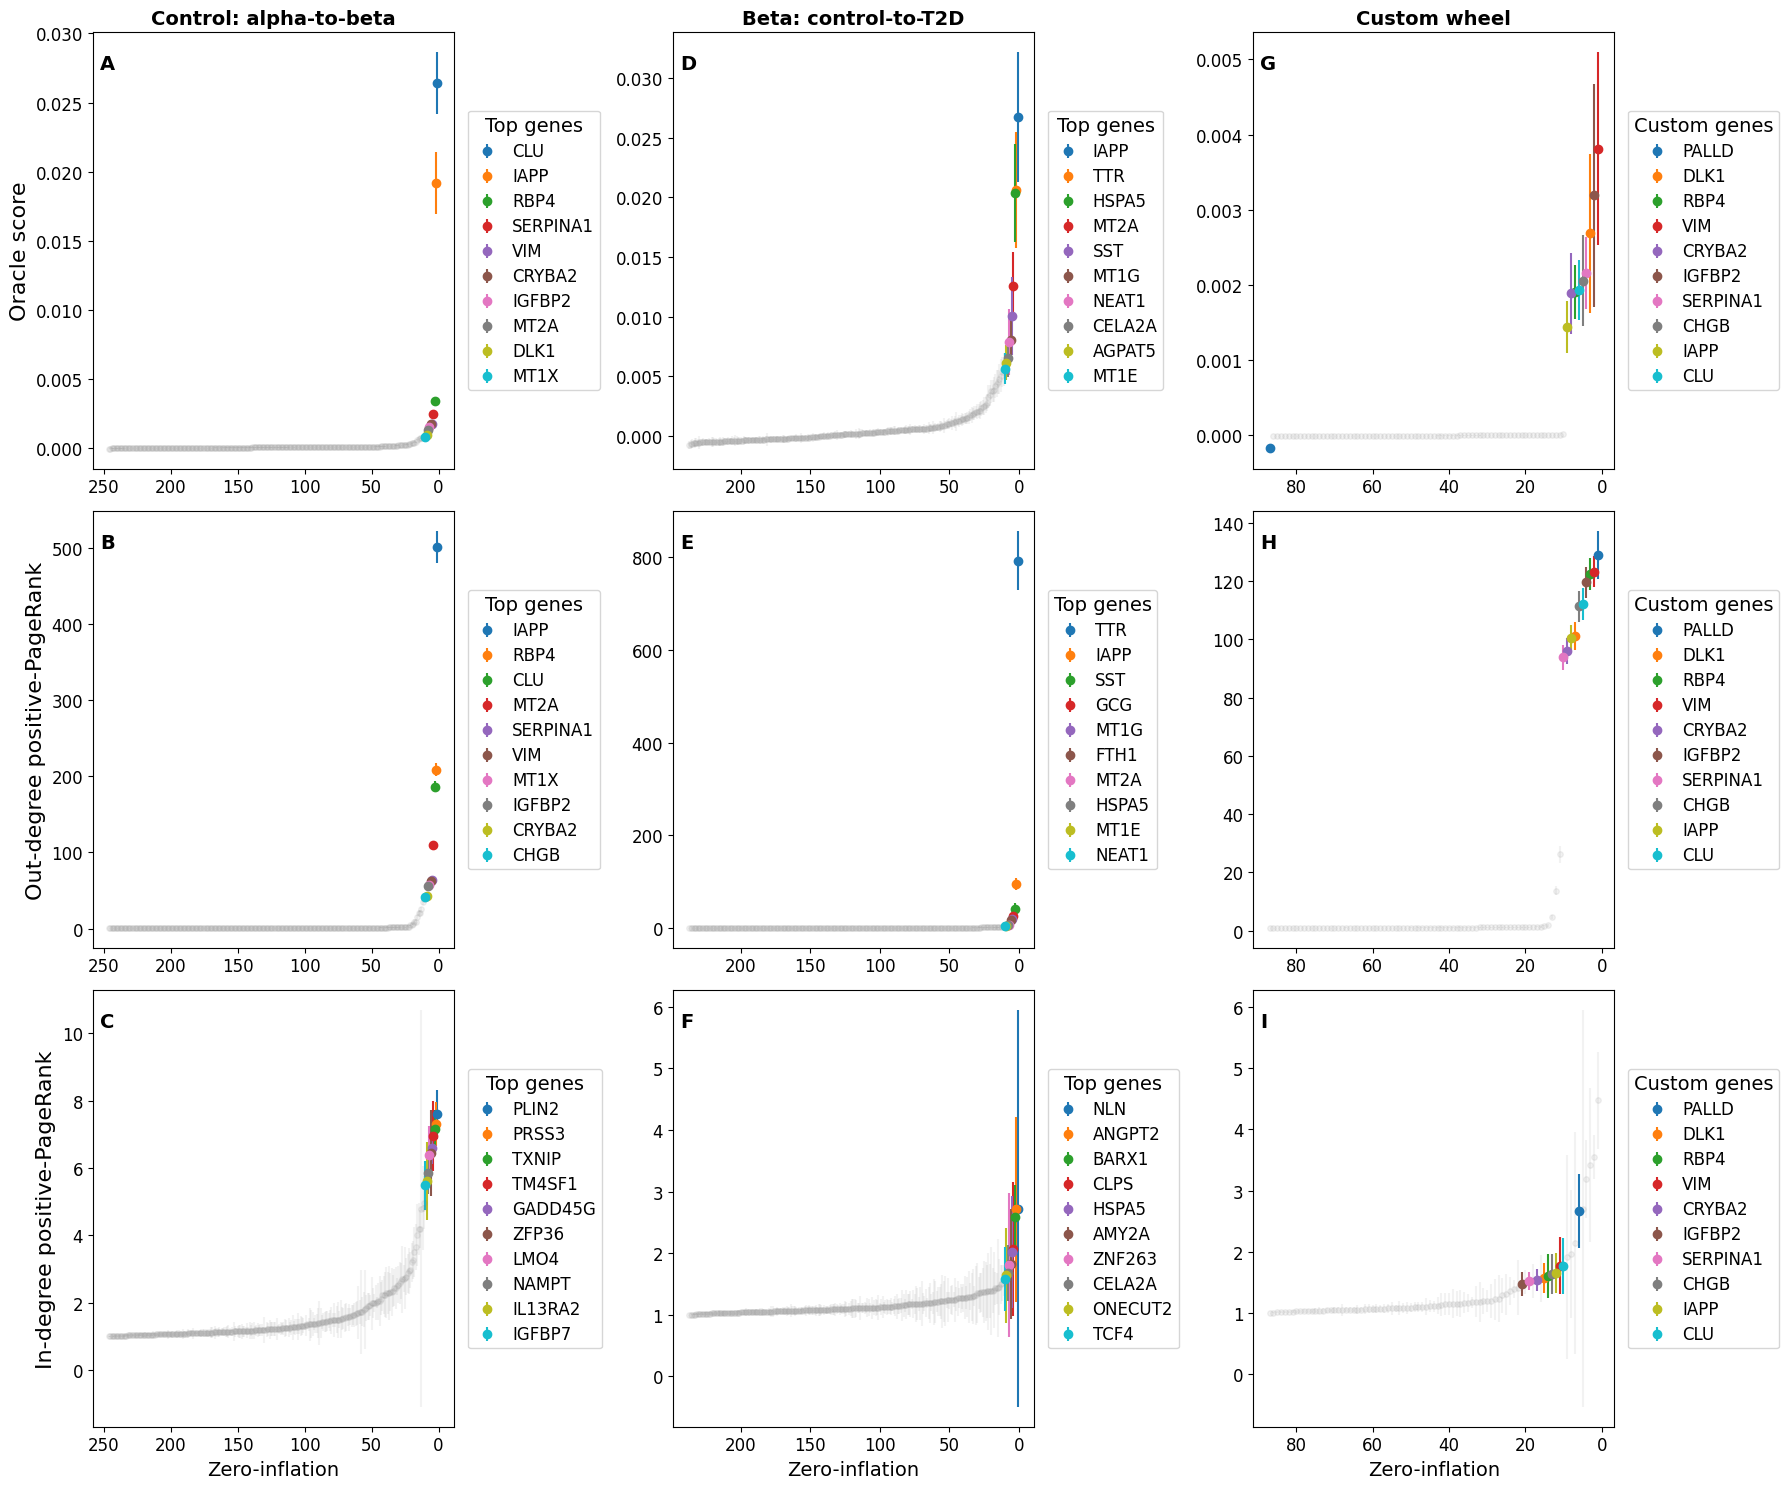

In [8]:

fig = assemble_multiplot_pval(
    dataframes=filtered_dfs, 
    score_columns=score_columns,
    label_col='label',
    dataset_names=['Control: alpha-to-beta', 'Beta: control-to-T2D', 'Custom wheel'],
    score_titles=['Oracle score', 'Out-degree positive-PageRank', 'In-degree positive-PageRank'],      # Custom column titles
    x_axis_label='Rank'  # Custom X-axis label
)
fig.savefig(main_path+'nozig_SimulationResults_acat_fdr_filtered.png')

In [9]:
print(umapa2b['state'].value_counts())
print(umapttoc['state'].value_counts())
print(umapwheel['state'].value_counts())

state
start    4992
goal     4967
Name: count, dtype: int64
state
start    3820
goal     3805
Name: count, dtype: int64
state
start    5000
goal     4997
Name: count, dtype: int64


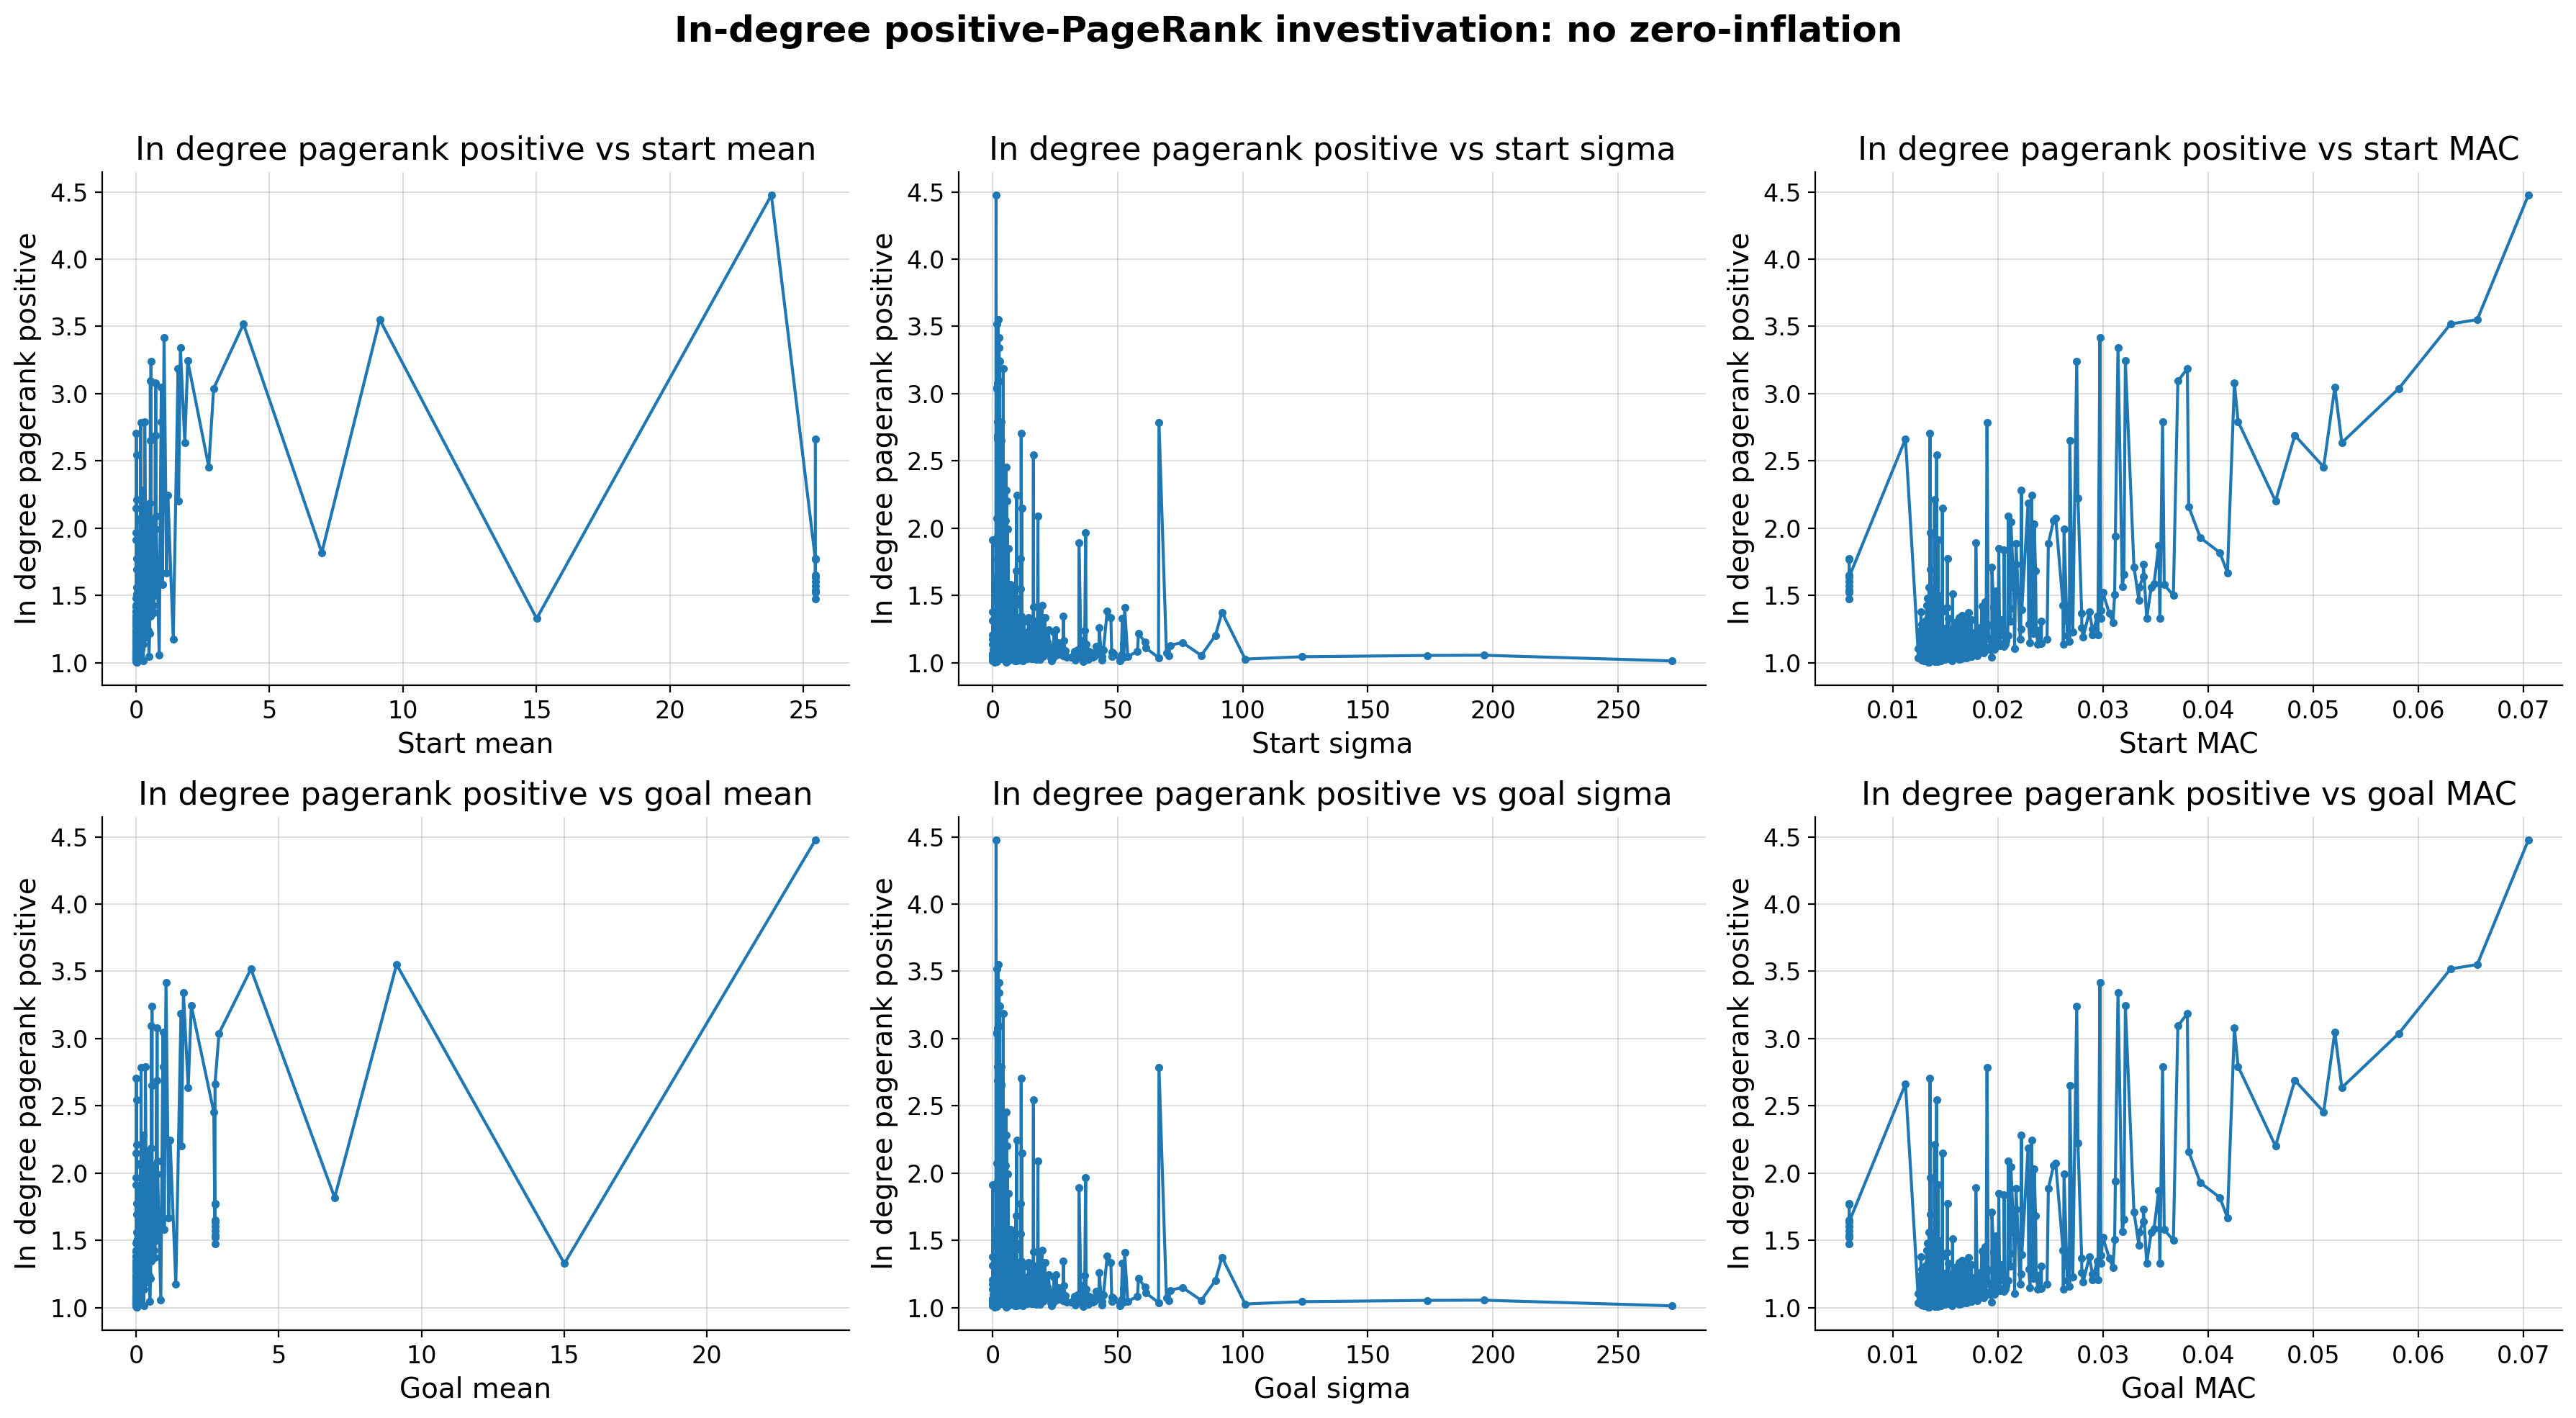

In [10]:
import re
def plot_sorted_line(df, x, y, ax=None, title=None, xlabel=None, ylabel=None):
    """
    Plot a line graph of y vs x after sorting the DataFrame by x.
    Text sizes tuned for a 6×4″ figure in a 12 pt–font paper with 1″ margins.
    """
    sorted_df = df.sort_values(by=x)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(sorted_df[x], sorted_df[y], marker='o', linestyle='-')

    # increase font sizes
    ax.set_title(title or f"{y} vs {x}", fontsize=18)
    ax.set_xlabel(xlabel or x, fontsize=16)
    ax.set_ylabel(ylabel or y, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)

    ax.grid(True)

    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return ax


import pandas as pd
import matplotlib.pyplot as plt
def _prettify_label(s: str) -> str:
    """
    Turn things like 'start_zero' -> 'Start zero', 'goal_MAC' -> 'Goal MAC'.
    Keeps all-caps tokens (e.g., MAC) as-is.
    """
    parts = re.split(r'[_\s]+', str(s).strip())
    pretty = []
    for p in parts:
        if p.isupper():  # keep acronyms (MAC, RNA, etc.)
            pretty.append(p)
        else:
            pretty.append(p)
    return " ".join(pretty)
    
def plot_grid_of_sorted_lines(
    df,
    x_cols,
    y_col,
    figsize=(18, 10),
    suptitle=None,
    dpi=200
):
    """
    Plot a 2×4 grid of line plots for one y column against 8 different x columns.
    Labels are prettified (no underscores) and typography is tuned for paper figures.
    """
    assert len(x_cols) == 6, "Exactly 6 x columns are required."

    # Create figure/axes
    fig, axes = plt.subplots(2, 3, figsize=figsize, dpi=dpi, constrained_layout=False)
    axes = axes.flatten()

    # Global font sizes (tuned for clarity in print/PDF)
    title_fs = 16
    label_fs = 14
    tick_fs = 12
    suptitle_fs = 18

    for i, x in enumerate(x_cols):
        ax = axes[i]
        # Drop rows with NaNs in either x or y to avoid broken lines
        subset = df[[x, y_col]].dropna()
        if subset.empty:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=label_fs)
            ax.set_axis_off()
            continue

        # Sort by x for a monotone line
        sorted_df = subset.sort_values(by=x)

        # Plot
        ax.plot(sorted_df[x].values, sorted_df[y_col].values, marker='o', linestyle='-', linewidth=1.5, markersize=3)

        # Titles/labels without underscores
        x_text = _prettify_label(x)
        y_text = _prettify_label(y_col)

        ax.set_title(f"{y_text.capitalize()} vs {x_text}", fontsize=title_fs)
        ax.set_xlabel(x_text[0].upper()+x_text[1:], fontsize=label_fs)
        ax.set_ylabel(y_text.capitalize(), fontsize=label_fs)


        # Ticks, grid, and spines
        ax.tick_params(axis='both', labelsize=tick_fs)
        ax.grid(True, linewidth=0.6, alpha=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Hide any unused axes (in case future callers pass fewer than 8)
    for j in range(len(x_cols), len(axes)):
        axes[j].set_axis_off()

    if suptitle:
        fig.suptitle(_prettify_label(suptitle), fontsize=suptitle_fs, fontweight='bold')

    # Tight layout with room for suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.95] if suptitle else None)
    return fig




# Loading
import pandas as pd
import pickle
with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/nbonlyrealistic_simulation_alpha_to_beta_custom/wheel_simulation_parameters.pkl', 'rb') as f:
    wheel_parameters = pickle.load(f)


row_mean_abs = {
    name: df.abs().mean(axis=1)
    for name, df in wheel_parameters['copula_list'].items()
}

row_mean_abs_df = pd.DataFrame(row_mean_abs)

investivation_of_wheel=pd.DataFrame({
    "start_mean":wheel_parameters['mean_mat'][wheel_parameters['covariate']['state']=="start"].iloc[1,:],
    "goal_mean":wheel_parameters['mean_mat'][wheel_parameters['covariate']['state']=="goal"].iloc[1,:],
    "start_sigma":wheel_parameters['sigma_mat'][wheel_parameters['covariate']['state']=="start"].iloc[1,:],
    "goal_sigma":wheel_parameters['sigma_mat'][wheel_parameters['covariate']['state']=="goal"].iloc[1,:],
    'start_MAC':row_mean_abs_df['start'],
    'goal_MAC':row_mean_abs_df['goal']
             }).merge(dataframes[2].groupby(dataframes[2].index)[['in_degree_pagerank_positive','out_degree_pagerank_positive','oracle_score']].mean(),left_index=True,right_index=True).sort_values('in_degree_pagerank_positive')
in_degree_investigation_plot=plot_grid_of_sorted_lines(
    df=investivation_of_wheel,
    x_cols=['start_mean', 'start_sigma', 'start_MAC', 'goal_mean', 'goal_sigma','goal_MAC'],
    y_col='in_degree_pagerank_positive',
    suptitle="In-degree positive-PageRank investivation: no zero-inflation"
)

in_degree_investigation_plot.savefig('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/nozig/extreme_sigma_sensitivity_nozig_wheel.png')

In [11]:

dataframes[2].groupby(dataframes[2].index)[['in_degree_pagerank_positive','out_degree_pagerank_positive','oracle_score']].mean()

,in_degree_pagerank_positive,out_degree_pagerank_positive,oracle_score
gene_name,,,
A2M,1.144745,1.041170,2.371582e-06
ADAMTS5,1.202510,1.008745,1.611403e-06
ADCY3,1.075108,1.012533,6.128003e-07
ADGRL2,1.230724,1.012339,6.224551e-07
ADIRF,1.092203,1.012810,-1.130322e-07
...,...,...,...
ZFP36,1.377837,1.106216,4.564857e-06
ZFP36L1,1.232909,1.055798,2.277028e-06
ZFP36L2,1.328566,1.508150,4.396219e-06


In [12]:
row_mean_abs_df['goal'].sort_values()

IGFBP2      0.005867
CRYBA2      0.005867
VIM         0.005867
IAPP        0.005867
SERPINA1    0.005867
              ...   
JUN         0.052707
IGFBP7      0.058129
S100A6      0.063043
JUND        0.065582
FTH1        0.070441
Name: goal, Length: 500, dtype: float64